# Create Image Classification Models using MZModel

This example shows you how to use the `dlpy.mzmodel` subpackage to create a ResNet18 model to classify images of fruits. The `dlpy.mzmodel` subpackage leverages the [SAS Deep Learning Model Zoo](https://go.documentation.sas.com/doc/en/pgmsascdc/latest/casdlmzpg/titlepage.htm) utilities to manage deep learning models on the CAS server.

## Table of Contents
1. [Set Up Environment](#setup)
2. [Prepare the Data](#prepare)
3. [Build the Model](#build)
4. [Train the Model](#train)
5. [Score the Model](#score)
6. [Save the Model](#save)

## Set Up Environment <a id="setup"><a>

First, import the various Python and SAS DLPy packages that will be used in this notebook session. Begin by importing the SAS Statistical Wrapper for Analytic Transactions (SWAT). SWAT is the Python interface to SAS CAS. Here is more information about [starting a SAS CAS session with the SWAT package](https://sassoftware.github.io/python-swat/getting-started.html).

In [1]:
import swat as sw
import sys
from dlpy.mzmodel import *
from dlpy.utils import *
from dlpy.images import *
from dlpy.splitting import two_way_split

Create a CAS session instance. Provide connection information to your running CAS server. For this example, assume the CAS server is hosted at `cloud.example.com` on port `5570`.

In [2]:
s = sw.CAS('cloud.example.com', 5570)

## Prepare the data <a id="prepare"></a>

If you have not already done so, you can download all of the required data for this notebook example in a zip file from the open-source [Horea94 Fruits-360 repository on GitHub](https://github.com/Horea94/Fruit-Images-Dataset). You can directly download the Horea94 2018 Fruit-Images-Dataset here(708MB).

The Fruit-Images-Dataset-Master zip archive contains Training and Test folders, each with subfolders for 131 labeled classes of fruit and vegetable images. The images are all 100px by 100px. Only the Test folder from the archive is required to complete this notebook example. (Always include LICENSE and README files.)

Load the images into CAS and create an `ImageTable` object named _ImgTbl_ that references the data.

In [3]:
ImgTbl = ImageTable.load_files(s, path='/path/to/fruit/directory', casout=dict(name='data'))

Use the `show()` method to display 6 random images from the newly created CAS table in a 3-columnn array.

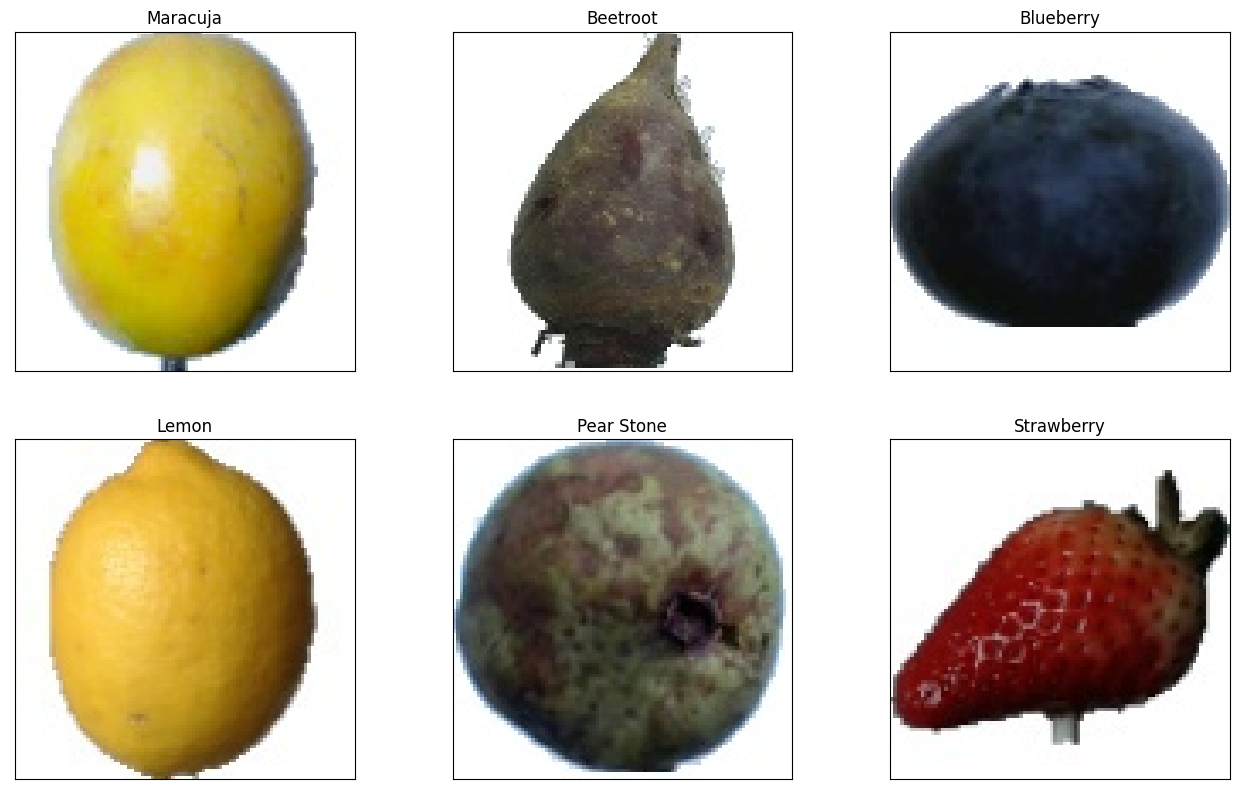

In [4]:
ImgTbl.show(6, ncol=3, randomize=True)

Currently, the SAS CAS session has an image table that contains 22,688 labeled images. Use the `two_way_split()` function to partition the contents of the image table. Setting the test_rate parameter to 15% means that 85% of the 22,688 (19,266) images from ImgTbl are allocated to the new train role table named train_data, and the remaining 15% (3,422) images are allocated to the new test role table named test_data.

In [5]:
train_data, test_data = two_way_split(ImgTbl, 
                                      test_rate=15, 
                                      seed=12345
                                      )

## Build the Model <a id="build"></a>

Create a ResNet18 model by using the `MZModel()` constructor. Because ResNet18 is available in the [Deep Learning Model Zoo](https://go.documentation.sas.com/doc/en/pgmsascdc/v_034/casdlmzpg/n09a2fh2c02g64n1jt0mlft8z428.htm), you can specify the architecture by using `type="torchNative"`, `name="resnet"` and `subtype="resnet18"`. Fit the model to the data set by specifying `num_classes=131` to account for the 131 classes in the fruit data set. If you have a set of weights for the architecture, you can begin training from that set of weights by setting the `model_path` to the path of the file that contains the weights.

In [6]:
model = MZModel(conn=s, 
                model_type = "torchNative", 
                model_name="resnet", 
                model_subtype="resnet18", 
                num_classes=131, 
                model_path = "/path/to/weights/resnet18.pt")

The model accepts 28 x 28 x 3 images in which the channels indicate BGR ordering by default. The data set provides images in 100 x 100 x 3 format. The `add_image_transformation()`method enables you to add an image transformation step to the pipeline so that the images are resized to the correct format before the model reads them.

In [7]:
model.add_image_transformation(image_size='28 28')

# Train the Model <a id="train"></a>

Before fitting the model, store hyperparameter values in variables. This approach makes for cleaner code and easier troubleshooting.

In particular, set the learning rate and batch size as ranges of values. When you specify a range for a hyperparameter the action tunes the hyperparameter for better perforamnce within the specified range.

In [8]:
lr=HyperRange(lower=5e-4, upper=1e-3)
batch_size=BatchSizeRange(lower=100, upper=150)

In [9]:
optimizer=Optimizer(seed=54321, 
                    algorithm=SGDSolver(lr=lr, momentum=0.9),
                    batch_size=batch_size,
                    max_epochs=3                   
                    )

In [10]:
tuner=Tuner(method="EAGLS", pop_size=10, max_func=10)

Having specified the optimization parameters, you can now start training the model. Use the `train()` method of the `MZModel` class to train the ResNet18 model. Use `inputs` to specify the column that contains the images and `targets` to specify the column that containst the image class. Note that the `_label_` column contains character data, but the ResNet model relies on numerical data. To convert the character data to numerical data, specify `index_variable="_label"_"`. Pass your optimizer and tuner settings along with any gpu settings.

In [11]:
model.train(table=train_data, 
            inputs="_image_", 
            targets="_label_", 
            index_variable="_label_", 
            gpu=[0, 1, 2, 3], 
            optimizer=optimizer, 
            tuner=tuner
           )

NOTE: Using this GPU List on your-server.unx.company.com: [0 1 2 3 ].
NOTE: Hypertuning mode is enabled.
NOTE: Worker rank 0: your-server.unx.company.com, using up to 4 GPU devices for hyperparameter tuning.
NOTE: In hyperparameter tuning, solving for 10 points.
NOTE: Using your-server.unx.company.com: GPU 0 processes job 0 in hyperparameter tuning up to 1 records at a time.
NOTE: Using your-server.unx.company.com: GPU 1 processes job 1 in hyperparameter tuning up to 1 records at a time.
NOTE: Using your-server.unx.company.com: GPU 2 processes job 2 in hyperparameter tuning up to 1 records at a time.
NOTE: Using your-server.unx.company.com: GPU 3 processes job 3 in hyperparameter tuning up to 1 records at a time.
NOTE: Starting dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 67177 device= GPU:0
NOTE: Starting dlxexe process on worker your-server.unx.company.com, rank/threadID [0/1], pid= 67178 device= GPU:1
NOTE: Starting dlxexe process on worker your-se

[TuningOptions]

           Option  Value
 0  Search Method  EAGLS
 1        maxFunc     10
 2        maxIter     10
 3        maxTime      0
 4        popSize     10

[HyperparameterValues]

    Tag  LearningRate  BatchSize        Loss
 0    4      0.000889        100  310.118218
 1    3      0.001000        122  337.417538
 2    9      0.000833        111  385.182428
 3   10      0.000944        139  427.291473
 4    2      0.000722        128  555.335860
 5    1      0.000778        150  611.748036
 6    7      0.000556        117  717.396466
 7    8      0.000500        106  717.946029
 8    5      0.000667        144  719.349836
 9    6      0.000611        133  746.239029

[TrainIterHistory]

     JobID  Epoch          Loss       MCE
 0     1.0    0.0  23060.720812  0.341283
 1     2.0    0.0  19119.272563  0.295421
 2     0.0    0.0  24622.916540  0.360480
 3     3.0    0.0  17984.492108  0.279361
 4     1.0    1.0   1372.134667  0.008579
 5     2.0    1.0    843.572577  0.003937
 6     0.0    1.0   1522.456992  0.008579
 7     3.0    1.0    810.583970  0.005177
 8     1.0    2.0    555.335860  0.000830
 9     2.0    2.0    337.417538  0.000208
 10    0.0    2.0    611.748036  0.000934
 11    3.0    2.0    310.118218  0.000208
 12    6.0    0.0  24882.980661  0.364238
 13    7.0    0.0  24657.215792  0.356564
 14    4.0    0.0  25674.654687  0.370258
 15    5.0    0.0  25540.842626  0.371979
 16    6.0    1.0   1767.850552  0.009711
 17    7.0    1.0   1773.327645  0.010019
 18    4.0    1.0   1775.239847  0.010944
 19    5.0    1.0   1815.278938  0.010225
 20    6.0    2.0    717.396466  0.001038
 21    7.0    2.0    717.946029  0.000726
 22    4.0    2.0    719.349836  0.000830
 23    5.0    2.0    746.239029  0.001452
 24    8.0    0.0  20025.023260  0.305690
 25    9.0    0.0  21480.063039  0.326660
 26    8.0    1.0    969.198296  0.005280
 27    9.0    1.0   1061.461327  0.005074
 28    8.0    2.0    385.182428  0.000311
 29    9.0    2.0    427.291473  0.000208

[TuningHistory]

    Tuning Iteration  Number of Evaluations  Best Objective
 0                 1                     10      310.118218

+ Elapsed: 129s, user: 7.65s, sys: 15.6s, mem: 136mb

Removing the optimizer allows training with learning rate and batch size that gave the best loss.

In [12]:
model.train(table=train_data, inputs="_image_", targets="_label_", index_variable="_label_", gpu=[0])

NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 100 records at a time.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 67177 device= GPU:0
NOTE: Learning Rate: 0.00089 Momentum:     0.9 Weight Decay:       0 Dampening:       0 BatchSize: 100 Rank: 0 Device: 0 Loss: 311.976
NOTE: The action completed successfully.


,Epoch,Loss,MCE
0,0.0,17997.784304,0.280282
1,1.0,792.031820,0.003937
2,2.0,311.976482,0.000104
,Tuning Iteration,Number of Evaluations,Best Objective


## Score the Model <a id="score"></a>

Use the `MZModel.score()` method to score the test data. When you run the `MZModel.score()` method, the score results are written to `MZModel.table_out`. The `MZModel.table_out` value is a `CASTable` that contains the labels in the `_label_` column, the predictions in the `_predClass_` and `_predName_` columns, and the filename in the `_filename_0` column.

In [13]:
model.score(table=test_data, inputs="_image_", targets="_label_", gpu=[0], batch_size=128)

NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 128 records at a time.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 67177 device= GPU:0
NOTE: The action completed successfully.


,Loss,MCE
0,65.636842,0.002918


Use the fetch() function to view the output table.

In [14]:
model.table_out.fetch()

,_image_,_label_,_filename_0,_id_,_predClass_,_predName_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Onion Red Peeled,r_4_100.jpg,12620,75,Onion Red Peeled
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Pear Red,r_88_100.jpg,15103,89,Pear Red
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Limes,r_189_100.jpg,10366,61,Limes
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Physalis,r_151_100.jpg,16933,97,Physalis
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Potato White,r2_70_100.jpg,18943,110,Potato White
5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Cucumber Ripe 2,r_26_100.jpg,6366,38,Cucumber Ripe 2
6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Potato Red Washed,r2_71_100.jpg,18503,108,Potato Red Washed
7,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Kiwi,49_100.jpg,9482,56,Kiwi
8,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Pineapple Mini,r_325_100.jpg,17139,100,Pineapple Mini
9,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Pepper Red,r2_196_100.jpg,16343,95,Pepper Red


## Save the Model <a id="save"></a>

An analytic store (astore) enables you to distribute the model, in a scorable format, to other SAS products, like SAS Model Manager. You can save the model as an analytic store (astore) by using the `save_to_astore()` method of the model. The `path` parameter is a client-side path to a directory where you would like to save the astore. The `file_name` parameter names the astore file. If the model contains an index variable, it will also be saved to the same astore file.

In [15]:
model.save_to_astore(path=r'\\path\to\astores', file_name="resnet_fruit_astore")

NOTE: Using this GPU List on your-server.unx.company.com: [].
NOTE: Worker rank 0: your-server.unx.company.com, using up to 0 GPU devices.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 67177 device= CPU
NOTE: 45093863 bytes were written to the table "Model_3nCj9N_astore" in the caslib "CASUSER(userID)".
NOTE: The action completed successfully.
NOTE: 45093863 bytes were downloaded from the table "MODEL_3NCJ9N_ASTORE" in the caslib "CASUSER(userID)".
NOTE: Model astore file saved successfully.
NOTE: Model index map saved successfully.


You can also save the model as a sashdat table by using the `save_to_table()` method. This is an important step to be able to retrain the model. The `path` parameter is a server-side path to a directory where you would like to save the sashdat file. The `file_name` parameter names the file and appends a .sashdat extension.

In [16]:
model.save_to_table(path='/path/to/model/table', file_name='resnet18_fruit')

NOTE: Cloud Analytic Services saved the file dlpy/resnet18.sashdat in caslib Caslib_Oq1EI9.
NOTE: Cloud Analytic Services saved the file dlpy/resnet18_index.sashdat in caslib Caslib_Oq1EI9.
NOTE: Model index map saved successfully.
NOTE: Model table saved successfully.
